# Pipeline for High-z Radio Galaxies 02: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag  = False
save_idx_flag   = False
read_idx_flag   = True
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect', 'LOFAR_detect', ] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [8]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [9]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 158483 elements,
54519 of them are marked as AGN, and 103964 are identified as galaxies.


---

## Possible correlations

In [10]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

Create target

$0$ for galaxies and $1$ for AGN

In [11]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [12]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str'])

## Split data: Test, Train, Validation

In [13]:
target_feat = 'class'

In [14]:
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   target_feat, use_calibration=use_calibration)
    
    print('Shape of used data in HETDEX')
    print('-' * 60)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 60)
    print()

Save indices of sources in validation sub-set for future steps.

In [15]:
if save_idx_flag:
    known_idx            = full_catalog_df.index.to_numpy()
    train_idx            = train_df.index.to_numpy()
    train_validation_idx = train_test_df.index.to_numpy()  # in the future, fix naming
    validation_idx       = test_df.index.to_numpy()  # in the future, fix naming
    calibration_idx      = calibration_df.index.to_numpy()
    test_idx             = validation_df.index.to_numpy()
    
    np.savetxt(fname=gv.indices_path + 'indices_known.txt',            X=known_idx,            fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_train.txt',            X=train_idx,            fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_train_validation.txt', X=train_validation_idx, fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_validation.txt',       X=validation_idx,       fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_calibration.txt',      X=calibration_idx,      fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_test.txt',             X=test_idx,             fmt='%i')

In [16]:
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
    print('Shape of used data in HETDEX')
    print('-' * 60)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 60)
    print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (158483, 80)
Data for Modeling (Train, Test, and Calibration): (126786, 80)
Training data:                                    (101428, 80)
Testing data:                                     (12679, 80)
Calibration data:                                 (12679, 80)
Validation data:                                  (31697, 80)
------------------------------------------------------------



---

## Use Correlation matrix to discard some features

In [17]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [18]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [19]:
rsd_vals

z_y          232.458088
i_z          200.404716
class        138.092387
i_y          125.562297
r_i          112.623664
y_W2         110.870255
g_r           97.367692
r_z           88.947183
y_W1          86.895323
z_W2          84.149761
r_y           80.993299
g_i           75.346971
z_W1          72.605160
g_z           70.473789
g_y           68.147251
i_W2          67.579388
i_W1          63.467732
H_W3          62.038335
r_W1          58.522420
r_W2          55.466002
g_W1          52.503388
g_W2          46.115354
y_J           45.290273
J_W3          45.282349
W1_W3         42.353070
y_H           41.118745
z_J           40.192240
J_H           38.379487
i_J           37.103832
z_H           36.773901
y_K           35.879931
r_J           35.727069
y_W3          35.201192
i_H           34.181314
r_H           33.359364
g_J           32.873759
z_K           32.663450
z_W3          31.966945
g_H           31.109258
W2_W3         31.028551
i_K           30.878914
H_K           30

In [20]:
correlation = norm_train_test_df.corr()

In [21]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [22]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [23]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [24]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [25]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'gmag',
 'rmag',
 'J_W2',
 'g_K',
 'ymag',
 'r_K',
 'imag',
 'zmag',
 'y_K',
 'i_K',
 'z_K',
 'W1mproPM',
 'W2mproPM',
 'H_W1',
 'K_W1',
 'g_W4',
 'r_W4',
 'K_W2',
 'J_W3',
 'y_W4',
 'i_W4',
 'z_W4',
 'g_W3',
 'Jmag',
 'W1_W4',
 'g_W2',
 'J_W4',
 'r_W3',
 'W2_W4',
 'y_W3',
 'i_W3',
 'z_W3',
 'W3mag',
 'r_W2',
 'g_y',
 'g_z',
 'J_K',
 'i_J',
 'Hmag',
 'z_J',
 'H_W2',
 'i_W1',
 'K_W3',
 'y_W1',
 'W2_W3',
 'z_W1',
 'g_W1',
 'i_W2',
 'z_W2',
 'g_J',
 'K_W4',
 'H_W4',
 'g_i',
 'r_y',
 'band_num']

In [26]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [27]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [28]:
corr_discard = norm_train_test_discard.corr()

In [29]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

W4mag  W4mag    1.000000
class  W1_W2    0.795335
y_J    r_J      0.738155
r_z    r_i      0.728260
y_J    y_W2     0.720253
r_J    r_W1     0.719486
r_z    r_W1     0.664380
r_W1   r_i      0.622150
W1_W2  W1_W3    0.613879
z_y    i_y      0.604553
W1_W3  y_J      0.589726
W3_W4  H_W3     0.588488
i_y    i_z      0.559534
H_K    Kmag     0.546634
W1_W2  r_W1     0.528590
dtype: float64

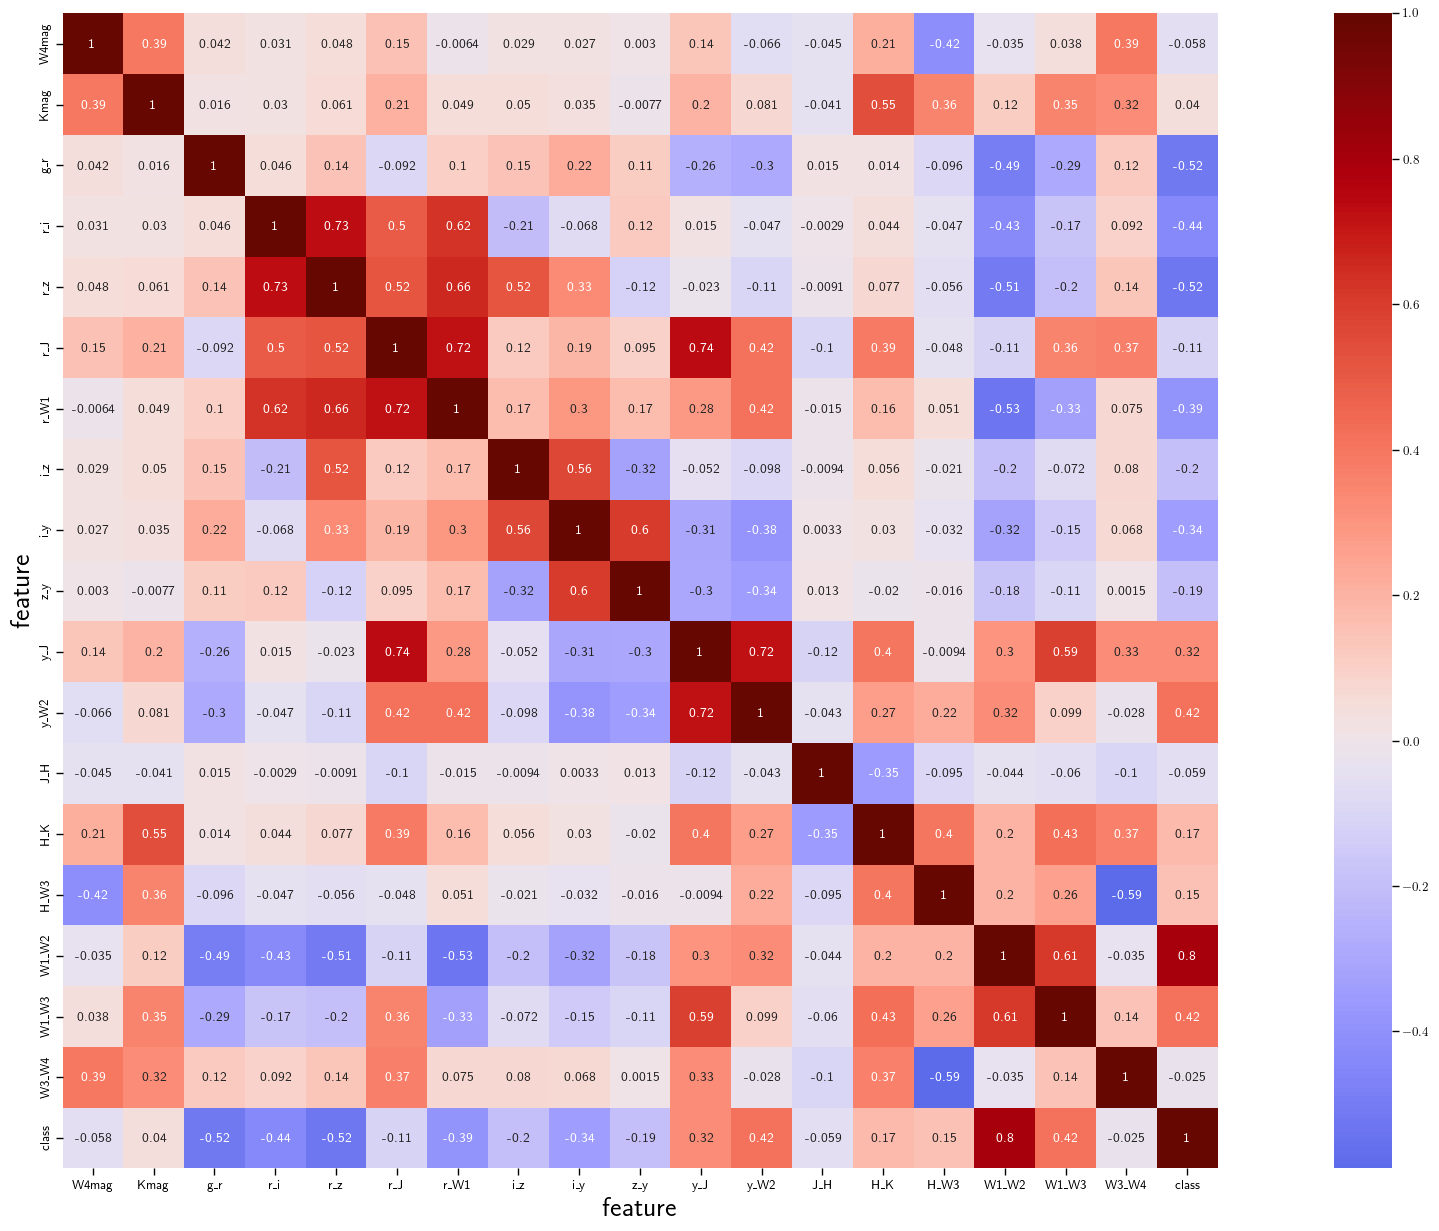

In [30]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [31]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [32]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [33]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
W1_W2  class    0.733044
g_r    class    0.583010
r_i    class    0.517292
class  W1_W2    0.502094
H_W3   W3_W4    0.498291
r_z    class    0.496402
H_W3   H_K      0.405048
r_z    r_i      0.394327
r_i    r_z      0.388920
J_H    H_K      0.352253
i_y    class    0.302990
W1_W3  class    0.284855
y_J    r_J      0.283956
y_W2   y_J      0.273021
       class    0.267822
r_W1   class    0.256279
class  g_r      0.253015
       r_z      0.252911
W1_W2  W1_W3    0.245531
dtype: float64

In [34]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [35]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [36]:
list_drop_pps = []

In [37]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [38]:
list_drop_pps

[]

In [39]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [40]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=gv.seed)

In [41]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.733044,classification,True,weighted F1,0.5496,0.879763,DecisionTreeClassifier()
1,g_r,class,0.583010,classification,True,weighted F1,0.5496,0.812188,DecisionTreeClassifier()
2,r_i,class,0.517292,classification,True,weighted F1,0.5496,0.782588,DecisionTreeClassifier()
3,r_z,class,0.496402,classification,True,weighted F1,0.5496,0.773180,DecisionTreeClassifier()
4,i_y,class,0.302990,classification,True,weighted F1,0.5496,0.686067,DecisionTreeClassifier()
5,W1_W3,class,0.284855,classification,True,weighted F1,0.5496,0.677899,DecisionTreeClassifier()
6,y_W2,class,0.267822,classification,True,weighted F1,0.5496,0.670227,DecisionTreeClassifier()
7,r_W1,class,0.256279,classification,True,weighted F1,0.5496,0.665028,DecisionTreeClassifier()
8,i_z,class,0.234157,classification,True,weighted F1,0.5496,0.655064,DecisionTreeClassifier()
9,y_J,class,0.215196,classification,True,weighted F1,0.5496,0.646524,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [42]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [43]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [44]:
exp_AGN = pyc.setup(data                     = train_df,
                    test_data                = test_df,
                    target                   = target_feat,
                    session_id               = gv.seed,
                    silent                   = True,
                    feature_selection        = False,
                    feature_selection_method = 'boruta',
                    data_split_stratify      = True,
                    numeric_features         = final_feats,
                    ignore_features          = feats_2_discard,
                    transformation           = True,
                    transformation_method    = 'yeo-johnson',
                    n_jobs                   = 12,
                    normalize                = True,
                    normalize_method         = 'zscore',
                    use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(101428, 80)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
pyc.get_config('X').columns

Index(['W4mag', 'Kmag', 'g_r', 'r_i', 'r_z', 'r_J', 'r_W1', 'i_z', 'i_y',
       'z_y', 'y_J', 'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4'],
      dtype='object')

In [47]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [48]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7f2bd99c0430>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [49]:
metric_to_optimize    = 'Recall'

In [50]:
final_selection_clf   = ['catboost', 'xgboost', 'et', 'rf', 'gbc', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
catboost,CatBoost Classifier,0.9615,0.9901,0.9394,0.9482,0.9437,0.9144,0.9145,0.9433,3.4480
xgboost,Extreme Gradient Boosting,0.9601,0.9894,0.9366,0.9468,0.9416,0.9113,0.9113,0.9412,10.0990
rf,Random Forest Classifier,0.9598,0.9878,0.9343,0.9482,0.9412,0.9107,0.9108,0.9405,2.0620
et,Extra Trees Classifier,0.9583,0.9871,0.9341,0.9442,0.9391,0.9075,0.9075,0.9387,0.6300
gbc,Gradient Boosting Classifier,0.9564,0.9876,0.9292,0.9434,0.9362,0.9031,0.9032,0.9355,4.0630
dummy,Dummy Classifier,0.6560,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0220


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [51]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0], 
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.9607,0.9895,0.9355,0.9494,0.9424,0.9125,0.9126,0.9418
1,0.9581,0.9904,0.9298,0.9474,0.9385,0.9068,0.9069,0.9377
2,0.9620,0.9891,0.9358,0.9530,0.9443,0.9155,0.9156,0.9435
3,0.9616,0.9908,0.9433,0.9451,0.9442,0.9150,0.9150,0.9441
4,0.9606,0.9894,0.9367,0.9481,0.9423,0.9124,0.9124,0.9418
5,0.9609,0.9913,0.9450,0.9415,0.9432,0.9134,0.9134,0.9434
6,0.9623,0.9893,0.9387,0.9512,0.9449,0.9163,0.9163,0.9443
7,0.9628,0.9908,0.9444,0.9474,0.9459,0.9176,0.9176,0.9457
8,0.9578,0.9900,0.9341,0.9427,0.9384,0.9063,0.9063,0.9380


In [52]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping=True, optimize=metric_to_optimize, 
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h15

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.9607,0.9880,0.9367,0.9484,0.9425,0.9126,0.9126,0.9419
1,0.9586,0.9887,0.9341,0.9449,0.9395,0.9080,0.9080,0.9390
2,0.9614,0.9882,0.9361,0.9508,0.9434,0.9141,0.9141,0.9427
3,0.9601,0.9897,0.9407,0.9431,0.9419,0.9115,0.9115,0.9418
4,0.9604,0.9883,0.9381,0.9462,0.9421,0.9120,0.9120,0.9418
5,0.9602,0.9896,0.9447,0.9398,0.9423,0.9119,0.9119,0.9425
6,0.9613,0.9881,0.9367,0.9500,0.9433,0.9139,0.9139,0.9426
7,0.9639,0.9892,0.9458,0.9491,0.9475,0.9200,0.9200,0.9473
8,0.9585,0.9889,0.9358,0.9431,0.9394,0.9079,0.9079,0.9391


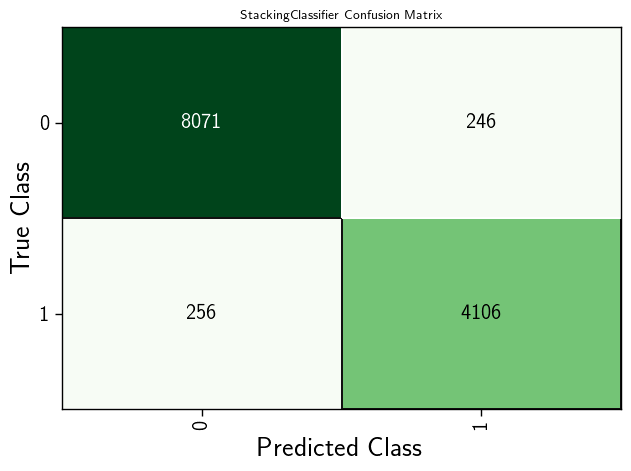

In [53]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

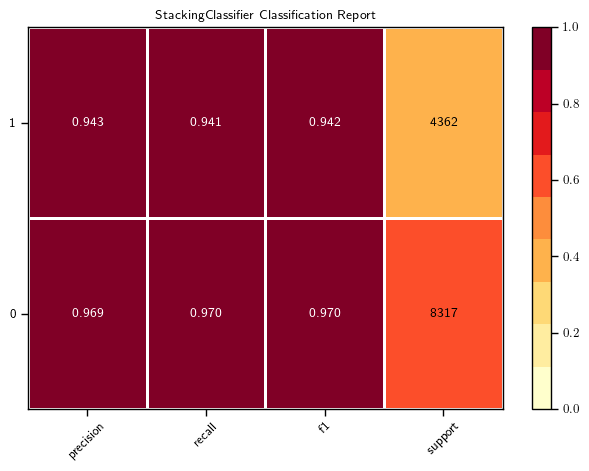

In [54]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

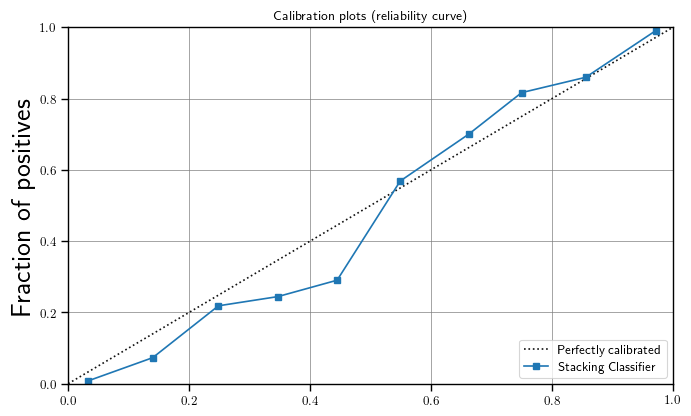

In [55]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

In [55]:
# pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='feature_all')

In [56]:
pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,14
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [57]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
depth,6
l2_leaf_reg,20
border_count,254
thread_count,12
verbose,False
random_strength,0.7537614045478824
task_type,CPU
n_estimators,14
random_state,42
eta,0.007534462160917973


In [58]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [59]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9604069722,0.9890196064,0.9413113251,0.9434742647,0.9423915538,0.9122305954,0.9122319896,0.9422888160


,Score_0,Score_1
count,12679.000000,12679.000000
mean,0.536625,0.463375
std,0.090853,0.090853
min,0.397653,0.385852
25%,0.412879,0.391665
50%,0.601426,0.398574
75%,0.608335,0.587121
max,0.614148,0.602347


In [60]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9604069722,0.9890196064,0.9413113251,0.9434742647,0.9423915538,0.9122305954,0.9122319896,0.9422888160


In [61]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [62]:
pyc.predict_model(final_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9604069722,0.9890196064,0.9413113251,0.9434742647,0.9423915538,0.9122305954,0.9122319896,0.9422888160


,Score_0,Score_1
count,12679.000000,12679.000000
mean,0.536625,0.463375
std,0.090853,0.090853
min,0.397653,0.385852
25%,0.412879,0.391665
50%,0.601426,0.398574
75%,0.608335,0.587121
max,0.614148,0.602347


In [63]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, gv.models_path + gv.AGN_gal_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [45]:
if load_model_flag:
    final_AGN_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [46]:
base_models_names = gf.get_base_estimators_names(final_AGN_clf)
base_models       = gf.get_base_estimators_models(final_AGN_clf)

In [47]:
print('Running data pre-processing:\n')
extended_data_AGN_df = gf.preprocess_data(final_AGN_clf, validation_df, base_models_names)

Running data pre-processing:



In [48]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_AGN_clf, extended_data_AGN_df)

In [49]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_AGN_df)

In [50]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [51]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for rf...
Calculating for et...
Calculating for gbc...


xgboost                 rf                 et                gbc           
   Feature Importance Feature Importance Feature Importance Feature Importance
0    W1_W2    57.1255   W1_W2    27.9007   W1_W2    29.5091   W1_W2    76.3993
1      r_z    13.2661     r_z    17.4251     g_r     9.6338     r_z    10.9574
2     y_W2     5.5054     g_r    14.4899    r_W1     8.6990     g_r     4.2226
3     Kmag     5.0206     r_i    10.7979    y_W2     8.4892    y_W2     3.8314
4    W1_W3     3.2987    y_W2     5.6429     r_z     7.7419   W1_W3     2.0000
5      g_r     2.7632    r_W1     3.9662     r_i     6.3610     r_J     0.8071
6     H_W3     1.5691     i_y     3.7349   W1_W3     6.0223     r_i     0.6742
7    W4mag     1.4334   W1_W3     2.9963     y_J     4.4994    r_W1     0.3472
8      r_i     1.4150     i_z     2.9727     i_y     3.9428    Kmag     0.1931
9    W3_W4     1.3981     r_J     2.8022     r_J     3.9416   W3_W4     0.1900
10     r_J     1.2213     y_J     2.1467     i_z     3.2209   W4mag     0.1403
11    r_W1     1.1999     z_y     1.4564     z_y     2.3483    H_W3     0.0817
12     H_K     1.0120     H_K     1.3053     H_K     1.5595     y_J     0.0728
13     y_J     0.9138    H_W3     0.9077    Kmag     1.0846     i_z     0.0288
14     i_y     0.8853   W3_W4     0.6250   W3_W4     1.0365     i_y     0.0207
15     i_z     0.7697     J_H     0.3932    H_W3     0.8097     J_H     0.0172
16     z_y     0.6547   W4mag     0.2478   W4mag     0.6069     H_K     0.0123
17     J_H     0.5482    Kmag     0.1890     J_H     0.4936     z_y     0.0039

In [52]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,gbc,41.1723,41.1723
1,et,18.3618,59.5341
2,rf,12.3733,71.9073
3,xgboost,10.3681,82.2754
4,W1_W2,5.0476,87.3230
5,W1_W3,2.8489,90.1719
6,y_J,2.3737,92.5456
7,H_K,1.4415,93.9872
8,g_r,1.0937,95.0809
9,i_z,1.0484,96.1293


In [125]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)# .drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W1_W2,51.2964,51.2964
r_z,61.3251,10.0287
g_r,68.0057,6.6806
W1_W3,73.4966,5.4909
y_W2,78.7171,5.2206
y_J,82.3074,3.5902
r_i,85.2357,2.9283
r_W1,88.0572,2.8215
i_z,90.1565,2.0993


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W2	51.296
r_z	10.029
g_r	6.681
W1_W3	5.491
y_W2	5.221
y_J	3.590
r_i	2.928
r_W1	2.822
i_z	2.099
H_K	1.999
r_J	1.529
i_y	1.479
Kmag	1.287
W3_W4	0.821
W4mag	0.820
H_W3	0.731
z_y	0.681
J_H	0.496


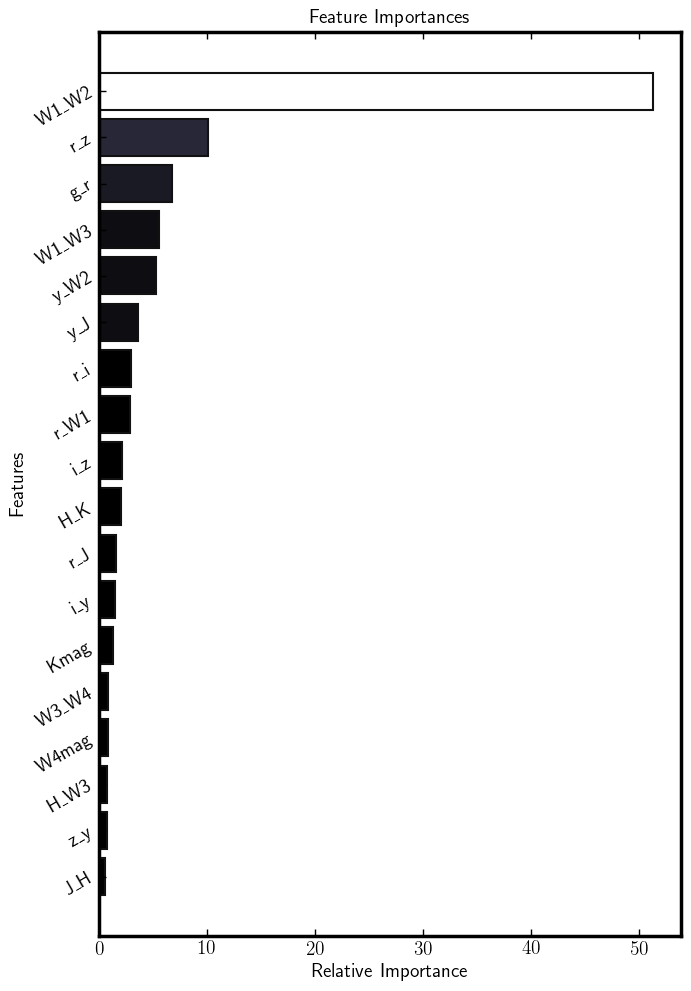

In [54]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [55]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_AGN_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,xgboost,rf,et,gbc
learning_rate,0.0075,0.3000,NaN,NaN,0.1000
depth,6.0000,NaN,NaN,NaN,NaN
random_strength,0.7538,NaN,NaN,NaN,NaN
l2_leaf_reg,20.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
subsample,NaN,1.0000,NaN,NaN,1.0000
max_depth,NaN,6.0000,NaN,NaN,3.0000
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN
reg_alpha,NaN,0.0000,NaN,NaN,NaN


---

In [56]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 101,428
Size of test set is  12,679


#### Calculate optimal threshold for classification

In [57]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9880900737,0.9995284852,0.9739195231,0.9913068845,0.9825362864,0.9735011250,0.9735888632


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9604069722,0.9890196064,0.9413113251,0.9434742647,0.9423915538,0.9122305954,0.9122319896


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9826006026,0.9976395216,0.9669609079,0.9821840285,0.9745130208,0.9613060867,0.9613736709


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9608801956,0.9901170091,0.9369410686,0.9486881820,0.9427780341,0.9130613923,0.9131022947


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9605640912,0.9885943581,0.9376375642,0.9471928849,0.9423910038,0.9124132803,0.9124403837


#### Naive threshold metrics.

In [58]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [59]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [60]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9817,0.9736,0.9913,0.9739
Test,0.9423,0.9122,0.9435,0.9413
Train+Test,0.9738,0.9614,0.9822,0.9670
Calibration,0.9422,0.9131,0.9487,0.9369
Validation,0.9419,0.9124,0.9472,0.9376


#### Calibration curve

In [61]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

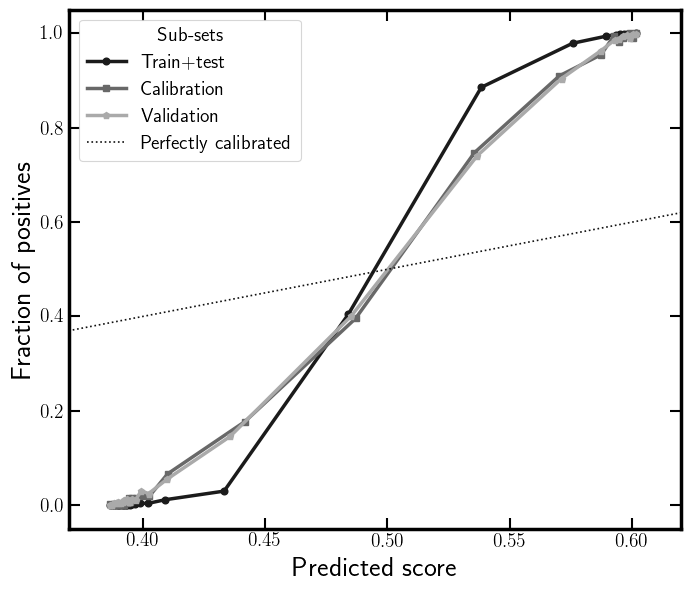

In [62]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=0.37, right=0.62)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [63]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [64]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99953
Area under the curve (ROC) for test       = 0.98902
Area under the curve (ROC) for train+test = 0.99764
Area under the curve (ROC) for calibraton = 0.99012
Area under the curve (ROC) for validation = 0.98859


In [65]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

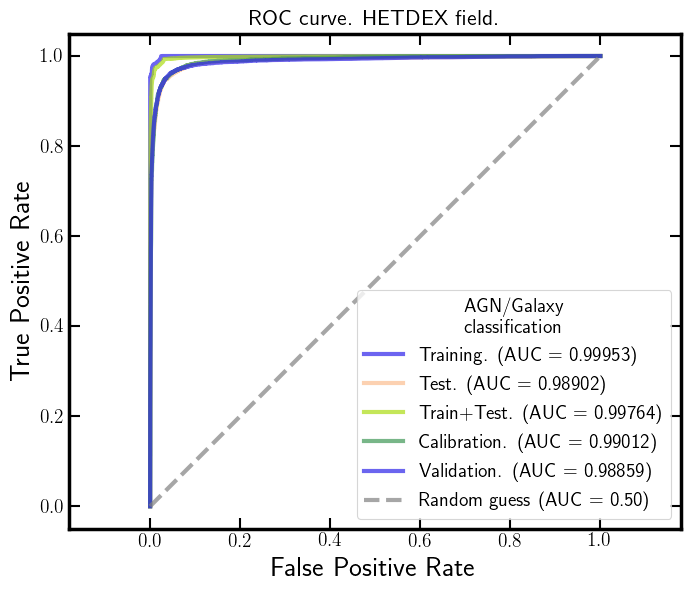

In [66]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [67]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [68]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_t_calib:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training    = 0.46983
Optimal threshold from area under the curve (ROC) for test        = 0.49131
Optimal threshold from area under the curve (ROC) for train+test  = 0.46981
Optimal threshold from area under the curve (ROC) for calibration = 0.48868
Optimal threshold from area under the curve (ROC) for validation  = 0.47817


##### Precision-Recall curve

In [69]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [70]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

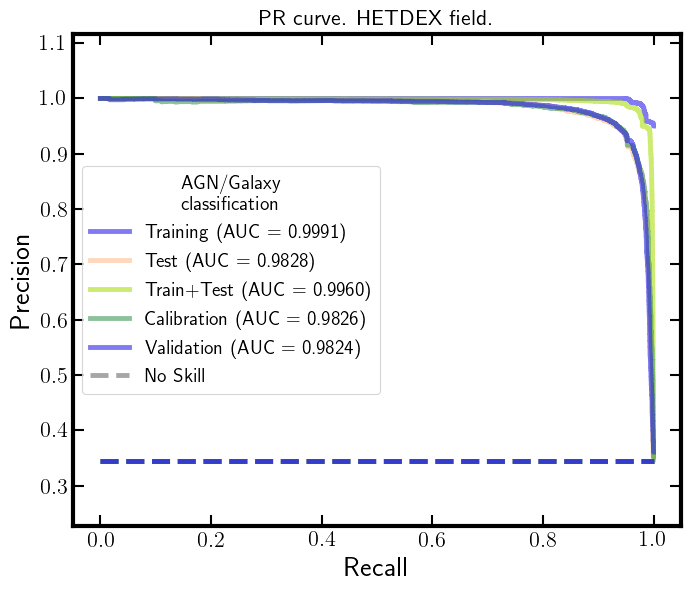

In [71]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [72]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [73]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [74]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training    = 0.49339
Optimal threshold from Precision-Recall curve for test        = 0.49131
Optimal threshold from Precision-Recall curve for train+test  = 0.49337
Optimal threshold from Precision-Recall curve for calibration = 0.48868
Optimal threshold from Precision-Recall curve for validation  = 0.48189


In [75]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.49337
And, in its complete extension, is 0.4933696292


---

In [76]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.43475

In [77]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9884943014,0.9995284852,0.9813710879,0.9851261544,0.9832450360,0.9744841522,0.9744882725


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9607224545,0.9890196064,0.9454378725,0.9406934307,0.9430596844,0.9130816451,0.9130883763


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9829791933,0.9976395216,0.9738392755,0.9766158516,0.9752255872,0.9622620190,0.9622642814


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9611168073,0.9901170091,0.9419857831,0.9448022079,0.9433918934,0.9137806059,0.9137829675


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9603747989,0.9885943581,0.9409391049,0.9437086093,0.9423218222,0.9121426721,0.9121449572


Create confusion matrices.

In [78]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [79]:
final_scores_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [80]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9831,0.9745,0.9851,0.9814
Test,0.9433,0.9131,0.9407,0.9454
Train+Test,0.9751,0.9623,0.9766,0.9738
Calibration,0.9433,0.9138,0.9448,0.9420
Validation,0.9422,0.9121,0.9437,0.9409


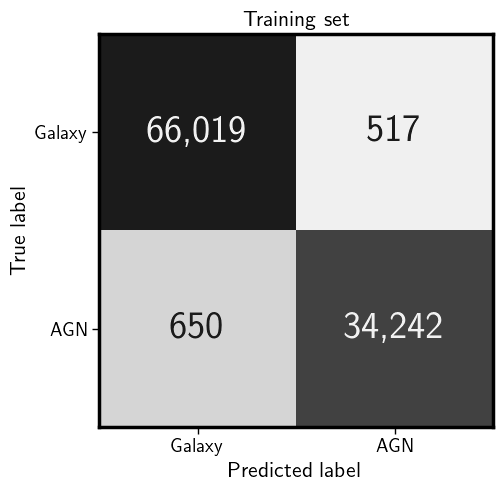

In [81]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

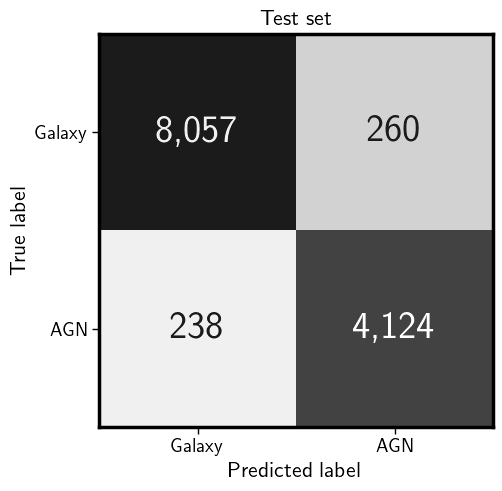

In [82]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

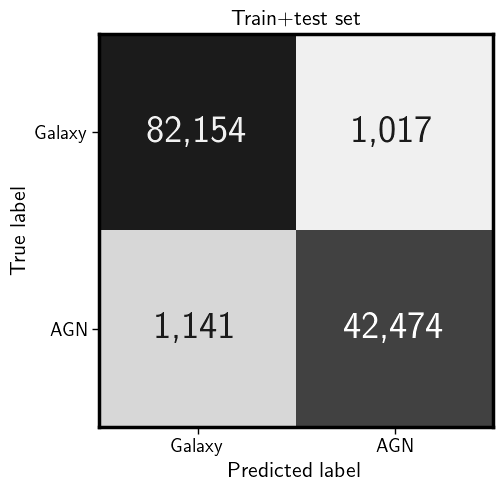

In [83]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

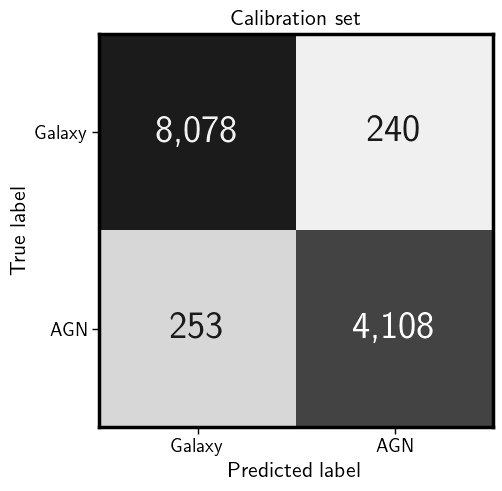

In [84]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

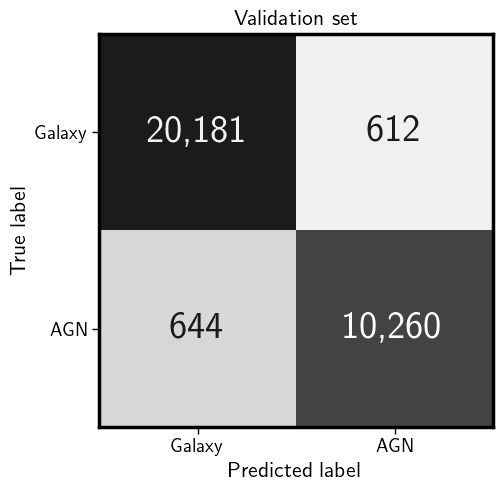

In [85]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [86]:
print('Running data pre-processing for calibration (calibration set):\n')
extended_calibration_df = gf.preprocess_data(final_AGN_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (calibration set):



In [87]:
if save_model_flag:
    calibrated_final_AGN_clf = BetaCalibration(parameters='abm')
    calibrated_final_AGN_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_AGN_clf, gv.models_path + gv.cal_AGN_gal_model)

In [88]:
if load_model_flag:
    calibrated_final_AGN_clf = load(gv.models_path + gv.cal_AGN_gal_model)

In [89]:
train_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_AGN']       = calibrated_final_AGN_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [90]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= gv.naive_AGN_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)

In [91]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [92]:
scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [93]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9826,0.9747,0.9903,0.9764
Test,0.9419,0.9114,0.9420,0.9418
Train+Test,0.9745,0.9622,0.9812,0.9691
Calibration,0.9426,0.9135,0.9481,0.9381
Validation,0.9421,0.9125,0.9465,0.9385


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [94]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_AGN'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)

AUC for PR curve

In [95]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

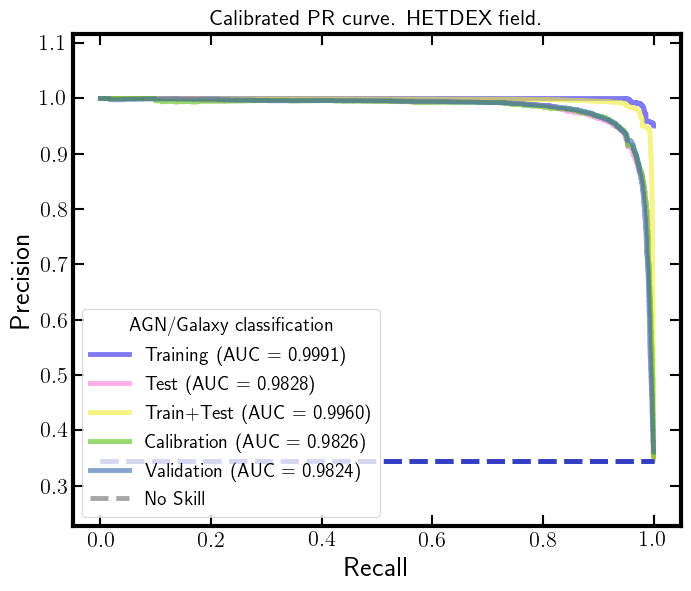

In [96]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [97]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [98]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [99]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.45415
Optimal threshold from Precision-Recall curve for test        = 0.43298
Optimal threshold from Precision-Recall curve for train+test  = 0.45394
Optimal threshold from Precision-Recall curve for calibration = 0.40655
Optimal threshold from Precision-Recall curve for validation  = 0.34090


In [100]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.40655
And, in its complete extension, is 0.40655238948425537


In [101]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)

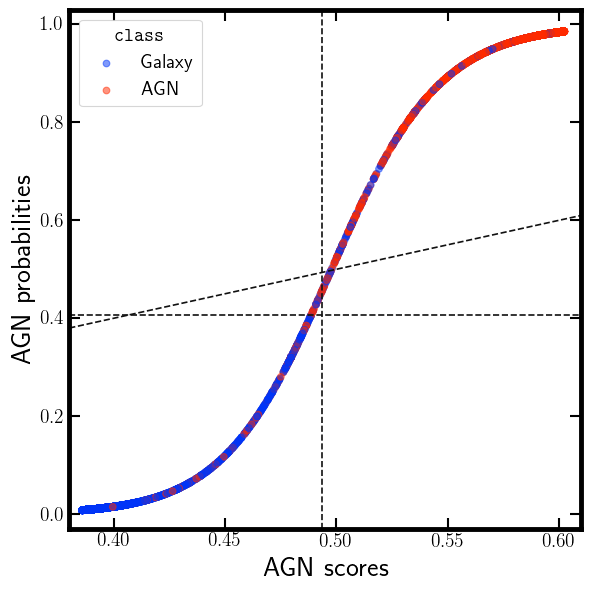

In [116]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
# ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_xlim(left=0.38, right=0.61)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

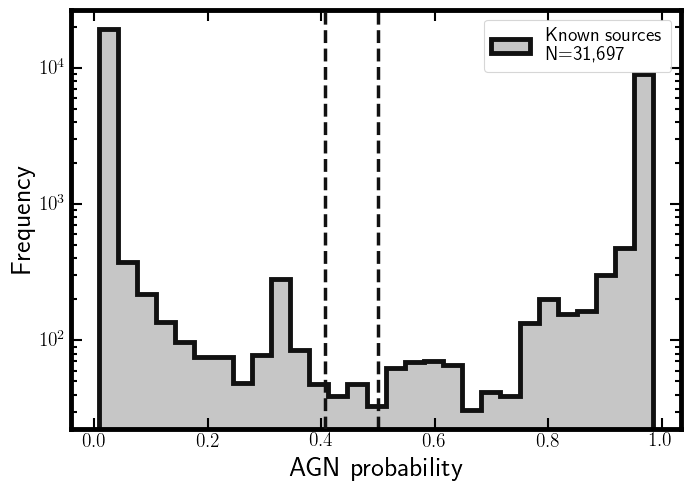

In [103]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_AGN'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_AGN'])

ax1.hist(set_to_plot.loc[:, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_AGN_cal_probs_validation.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [104]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

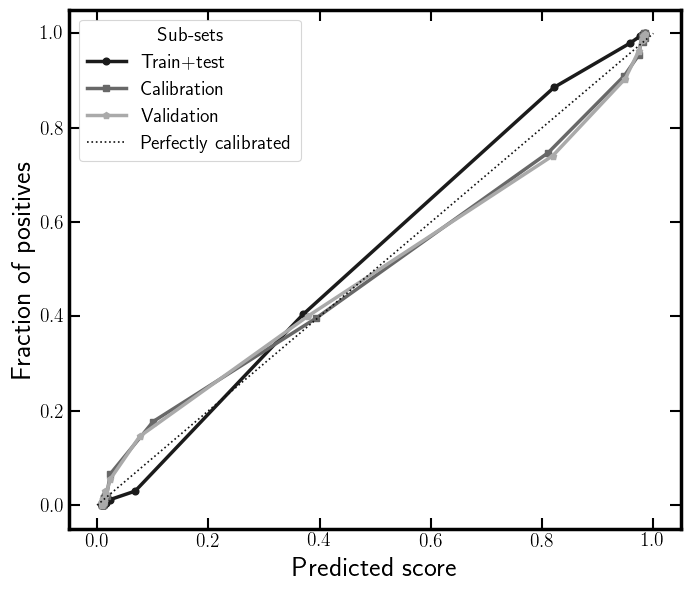

In [105]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [106]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [107]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.003 using the validation set.


Create confusion matrices.

In [108]:
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])

In [109]:
scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal, cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [110]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9810,0.9707,0.9787,0.9829
Test,0.9420,0.9105,0.9355,0.9475
Train+Test,0.9735,0.9591,0.9708,0.9757
Calibration,0.9447,0.9155,0.9431,0.9461
Validation,0.9424,0.9120,0.9413,0.9432


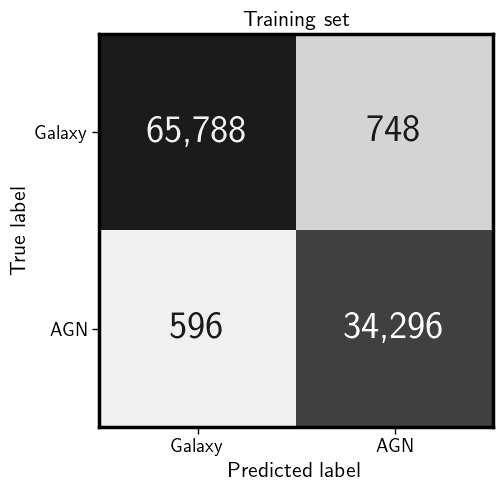

In [111]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

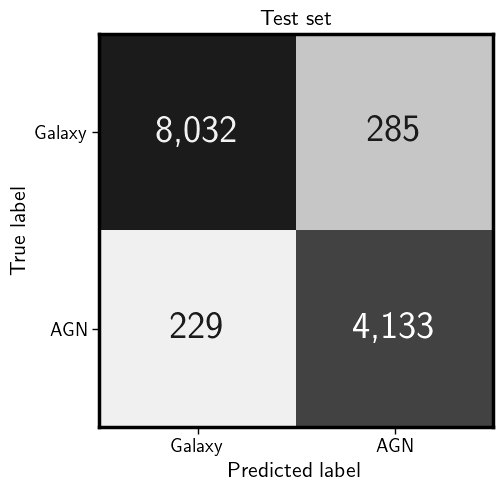

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

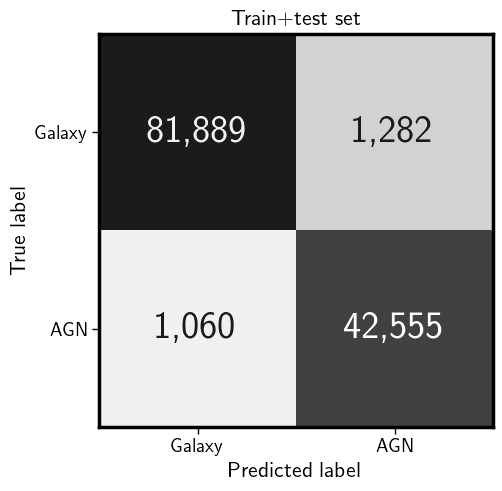

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

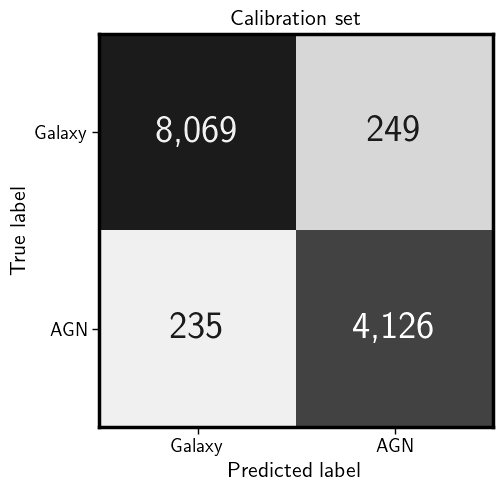

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

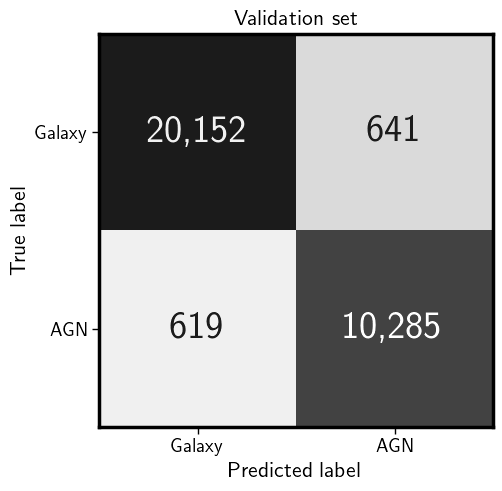

In [115]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()